## Text Mining II. Music Recomendation Based on Moods

#### Data Preparation

In [58]:
import nltk
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tree import Tree
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
nltk.download([
    "words",
    "punkt",
    "wordnet",
    "punkt_tab",
    "stopwords",
    "maxent_ne_chunker",
    "vader_lexicon",
])

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package vader_lexico

True

In [60]:
FILE_PATH_EMOTION = './dataset/combined_emotion.csv'
FILE_PATH_SONG = './dataset/data_moods.csv'

In [61]:
df_emotion = pd.read_csv(FILE_PATH_EMOTION)
print(df_emotion.count(), '\n')
print(df_emotion["emotion"].unique(), '\n')
print(df_emotion.head(), '\n')

df_song = pd.read_csv(FILE_PATH_SONG)
print(df_song.head())

sentence    422746
emotion     422746
dtype: int64 

['fear' 'sad' 'love' 'joy' 'suprise' 'anger'] 

                                            sentence emotion
0      i just feel really helpless and heavy hearted    fear
1  ive enjoyed being able to slouch about relax a...     sad
2  i gave up my internship with the dmrg and am f...    fear
3                         i dont know i feel so lost     sad
4  i am a kindergarten teacher and i am thoroughl...    fear 

                                          name                        album  \
0                                         1999                         1999   
1                                           23                           23   
2                                     9 Crimes                            9   
3                               99 Luftballons               99 Luftballons   
4  A Boy Brushed Red Living In Black And White  They're Only Chasing Safety   

           artist                      id release_date  

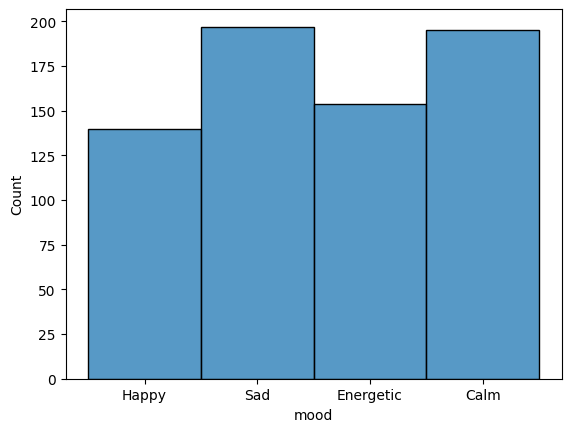

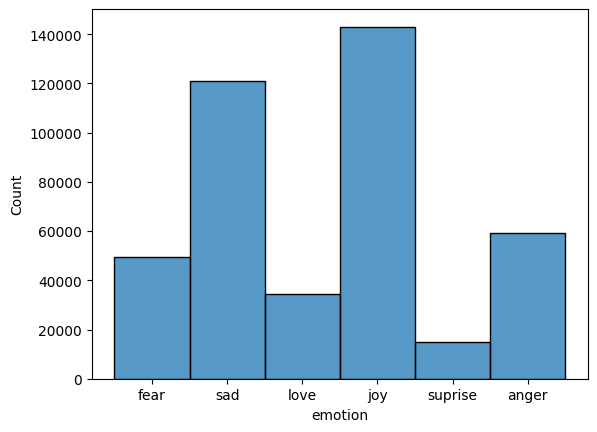

In [62]:
sns.histplot(df_song["mood"])
plt.show()
sns.histplot(df_emotion["emotion"])
plt.show()

### Data Processing

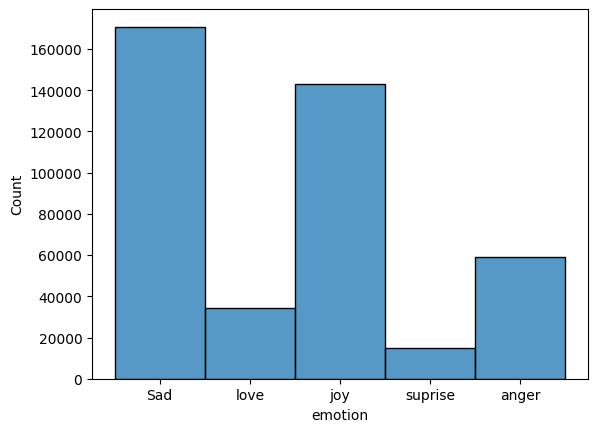

In [63]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'fear': 'Sad', 'sad': 'Sad'})
sns.histplot(df_emotion["emotion"])
plt.show()

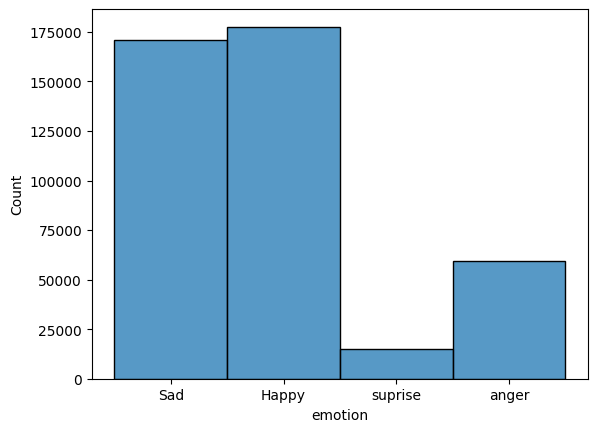

In [64]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'love': 'Happy','joy': 'Happy'})
sns.histplot(df_emotion["emotion"])
plt.show()

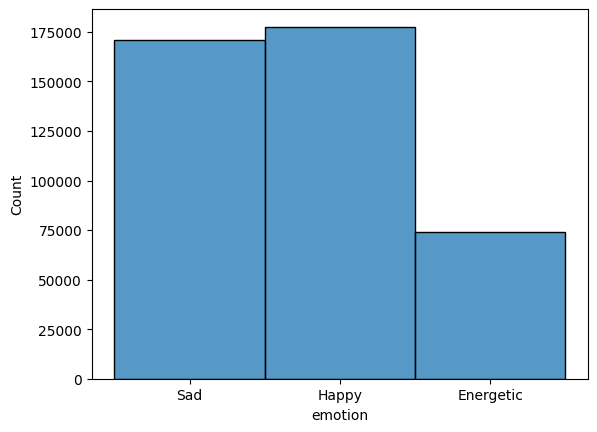

In [65]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'suprise': 'Energetic','anger': 'Energetic'})
sns.histplot(df_emotion["emotion"])
plt.show()

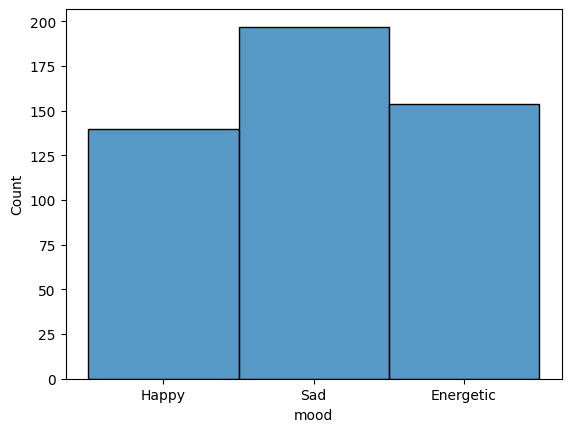

In [66]:
df_song['mood'] = df_song['mood'].drop(df_song[df_song['mood'] == 'Calm'].index)
sns.histplot(df_song["mood"])
plt.show()

### Model for Mood Analysis

##### Load & Process Dataset

In [67]:
sentence = df_emotion['sentence']
emotion = df_emotion['emotion']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    sentence,
    emotion,
    test_size=0.3,
    random_state=42
)

##### Compute TF-IDF Features

In [69]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

##### Training Model

In [70]:
model = ComplementNB()
model.fit(
    X_train_tfidf, 
    y_train
)

ComplementNB()

Accuracy: 91.72%
Labels present in y_test: ['Energetic', 'Happy', 'Sad']


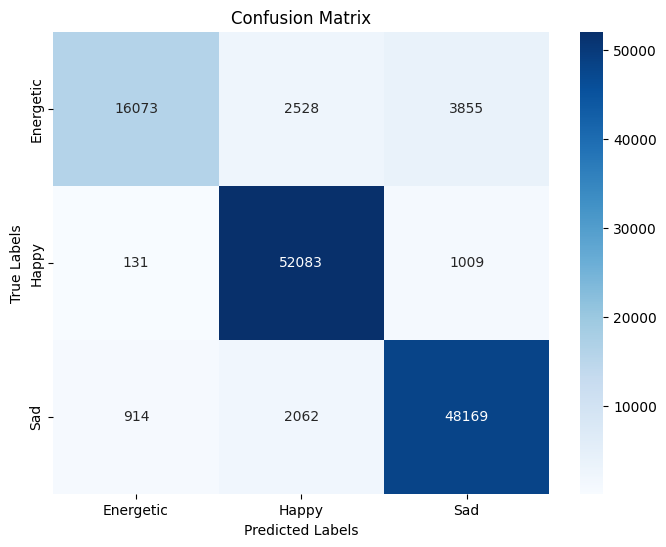

In [71]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

print("Labels present in y_test:", sorted(set(y_test)))

confusionMatrix = confusion_matrix(y_test, y_pred)
class_labels = sorted(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Sample in Training

In [72]:
for sentence, true_label, predicted_label in zip(X_test[:10], y_test[:10], y_pred[:10]):
    print(f"User Input: {sentence}")
    print(f"True Mood: {true_label} | Predicted Mood: {predicted_label}")
    print("-" * 50)

User Input: i feel like i ve been convinced by some indian guys to go horseback riding with the dalton brothers in cappadocia
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i love the insular feel of island living how genuinely weird islanders are it seems to be a prerequisite that you have to be a little off kilter to choose living somewhere one can only access by boat and of course i love being surrounded by the ocean
True Mood: Sad | Predicted Mood: Happy
--------------------------------------------------
User Input: i have a feeling that she wasnt thrilled
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i have to say since i am feeling so good about myself i have been making time to look more fashionable cute lately
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i feel deeply disturbed that young canadian universit

### Music Recomendation

In [73]:
def recommend_song(emotion, df_song, top_n=10):
    recommended_songs = df_song[df_song['mood'] == emotion].sort_values(by='popularity', ascending=False).head(top_n)[['name', 'album', 'artist', 'mood']]
    return recommended_songs

In [74]:
def predict_mood(user_input):
    user_input_tfidf = vectorizer.transform([user_input])
    return model.predict(user_input_tfidf)[0]

In [75]:
nlp = spacy.load("en_core_web_sm")
def extract_entities(text):
    doc = nlp(text)
    spacy.displacy.render(doc, style="ent", jupyter=True)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    return entities

### Menu Section

In [76]:
request = "NO REQUEST"
while True:
    print("\nMUSIC RECOMMENDATION APPLICATION BASED ON MOODS")
    print(f"YOUR REQUEST: {request}")
    print(f"YOUR MOOD: {'UNKNOWN' if request == 'NO REQUEST' else predict_mood(request).item()}")
    print("1. WRITE YOUR REQUEST")
    print("2. VIEW MUSIC RECOMMENDATION")
    print("3. VIEW NAMED ENTITIES RECOGNITION")
    print("4. EXIT")
    
    choice = input(">> ")
    
    if choice == "1":
        request = input("Enter your request: ")
    elif choice == "2":
        if request == "NO REQUEST":
            print("No request found. Please write a request first.")
        else:
            mood = predict_mood(request)
            print(f"Predicted Mood: {mood}")
            print("Recommended Songs:")
            print(recommend_song(mood, df_song))
    elif choice == "3":
        if request == "NO REVIEW":
            print("No request found. Please write a request first.")
            input("Press Enter to continue...")
        else:
            print("Named Entities:")
            extract_entities(request)
    elif choice == "4":
        print("Exiting...")
        break
    else:
        print("Invalid choice. Please select a valid option.")



MUSIC RECOMMENDATION APPLICATION BASED ON MOODS
YOUR REQUEST: NO REQUEST
YOUR MOOD: UNKNOWN
1. WRITE YOUR REQUEST
2. VIEW MUSIC RECOMMENDATION
3. VIEW NAMED ENTITIES RECOGNITION
4. EXIT
Exiting...
